In [2]:
import numpy as np
import math
import pandas as pd
import hashlib, random
from sklearn.mixture import GaussianMixture
import copy
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import jsonpickle
from random import shuffle
from collections import defaultdict
import os, json
from datetime import datetime
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random, json
from tqdm import trange, tqdm
from operator import itemgetter
from analyzer import *
import query_gen

sns.set(style='ticks', palette='coolwarm') #this overwrites matplotlib setting so make it run first 

# def set_font():
import matplotlib
# http://ishxiao.com/blog/python/2017/07/23/how-to-change-the-font-size-on-a-matplotlib-plot.html

font = {'weight' : 'bold',
#         'size'   : 20,
       'family': 'Linux Libertine O'}
matplotlib.rc('font', **font)

/local/xi/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def analyze_ratio(results):
    cnt_mean_ratios = {}
    sum_mean_ratios = {}
    cnt_median_ratios = {}
    sum_median_ratios = {}
    cnt_ratios = {}
    sum_ratios = {}
    gt = results['GT']
    for name, result in results.items():
        if name == 'GT':
            continue
#         print(name)
#         print(gt)
#         print(result)
        cnt_ratio = [float(b[0])/float(g[0]) for b, g in zip(result, gt)]
        cnt_mean_ratios[name] = np.mean(cnt_ratio)
        cnt_median_ratios[name] = np.median(cnt_ratio)
#         print(pd.DataFrame(cnt_ratio).describe())
        sum_ratio = [float(b[1])/float(g[1]) for b, g in zip(result, gt)]
        sum_mean_ratios[name] = np.mean(sum_ratio)
        sum_median_ratios[name] = np.median(sum_ratio)
        sum_ratios[name] = sum_ratio
        cnt_ratios[name] = cnt_ratio
    return cnt_ratios, sum_ratios, cnt_mean_ratios, cnt_median_ratios, sum_mean_ratios, sum_median_ratios

def plot_columns(mean, median, ylabel='Bound/GroundTruth Ratio', 
                 xlabel='Mean and Median', bar_labels=['Mean Ratio', 'Median Ratio'],
                log_scale = True, yrange= None):
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    baselines = mean.keys()
#     print(baselines)
    if yrange is None:
        yrange = [0, max(max(mean.values()), max(median.values())) + 1]
    fig, ax = plt.subplots(1,1,figsize=(18,8))
    
    xfont = {'weight' : 'bold',
            'size'   : 22}

    width = 0.3
    
    mean_bar = [perf for perf in mean.values()]
    median_bar = [perf for perf in median.values()]

    r0 = np.arange(len(mean_bar))
    r1 = [x - 0.15 for x in r0]
    r2 = [x + width for x in r1]
#     print(mean_bar, median_bar)
    ax.bar(r1, mean_bar, width, edgecolor='black', label=bar_labels[0], hatch=patterns[0])
    ax.bar(r2, median_bar, width, edgecolor='black', label=bar_labels[1], hatch=patterns[1])
    ax.set_xticks(np.arange(len(baselines)))
    ax.set_xticklabels(baselines, fontsize='x-large')
    
    ax.hlines(1.0, -0.5, len(baselines)-0.5, linestyle='--', color='gray', linewidth=4, label='Ground Truth')
    
    ax.set_ylabel(ylabel, fontdict = xfont)
    
    ax.set_ylim(yrange)
    
    if log_scale:
        ax.set_yscale('log')
        
    ax.legend()
    
#     matplotlib.pyplot.sca(ax)
    print(yrange)

    plt.legend(fontsize=20, loc='upper left')
    ax.set_xlabel(xlabel, fontdict = xfont)
    fig.tight_layout()
    plt.show()

    
# https://seaborn.pydata.org/tutorial/color_palettes.html
def plot_box(cnt_ratios, sum_ratios, ylabel='Bound/GroundTruth Ratio', xlabel='Mean and Median', bar_labels=['COUNT(*)', 'SUM(Light)']):
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    baselines = cnt_ratios.keys()
#     print(max([max(r) for r in cnt_ratios.values()]), max(cnt_ratios.values()))
#     yrange = [0, max(max([max(r) for r in cnt_ratios.values()]), max([max(r) for r in sum_ratios.values()])) + 1]
    fig, ax = plt.subplots(1,1,figsize=(18,8))
    xfont = {'weight' : 'bold',
            'size'   : 22}

    width = 0.5
    
    cnt_box = [perf for perf in cnt_ratios.values()]
    sum_box = [perf for perf in sum_ratios.values()]

    r0 = np.arange(len(cnt_ratios))
    r1 = [x - 0.15 for x in r0]
    r2 = [x + width for x in r1]
#     print(mean_bar, median_bar)
    ax.boxplot(cnt_box, positions = r1, showfliers=False)
    ax.boxplot(sum_box, positions = r2, showfliers=False)
    ax.set_xticks(np.arange(len(baselines)+1))
    ax.set_xticklabels(baselines, fontsize='x-large')

    ax.hlines(1.0, -1, len(baselines)+1.5, linestyle='--', color='gray', linewidth=2, label='Ground Truth')

    ax.set_ylabel(ylabel, fontdict = xfont)
    ax.set_xlim([-1, len(baselines)+1])
#     ax.set_ylim(yrange)
#         ax.set_yscale("log")

    ax.legend()

    #     matplotlib.pyplot.sca(ax)

#         plt.legend(fontsize=20, loc='upper left')
#     ax.set_xlabel(xlabel, fontdict = xfont)
    fig.tight_layout()
    plt.show()

In [4]:


def restore_obj(path):
    try:
        with open(path) as f:
            s = f.read()
            data = jsonpickle.decode(s, keys = True)
            print("Loaded %s" % path)
            return data
    except Exception as e:
        print("failed to restore", path, e)
        return None

def load_and_merge(config):
    # load all the files and merge them together because we have different files representing different partition type.
    baseline_perf = defaultdict(dict)
    queries = None
    for name, path in config.items():
        path = '/local/xi/VarAcc/src/cache/'+path
        if 'json' in path:
            data = json.load(open(path))
        else:
            data = restore_obj(path)
        if name == 'GT':
            queries = data
        else:
            k = name.split('-')[0]
            for base, perf in data.items():
                baseline_perf[k][base] = perf
    return queries, baseline_perf


In [5]:
!hostname

vulture


In [6]:
ds_name = "IntelWireless"

n_queries = {'random':2000}
gts = {'random':'IntelWireless-RangeSumQuery-itime-light-2000.jpk'}

srs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

k_depths =[
          [7,64]
        ]

baselines=[
        {'alias':"PASS", 'name':"DP_AMAX"}, 
        {'alias':"US", 'name':"EqualDepthPartitioner"}, 
        {'alias':"ST", 'name':"EqualDepthPartitioner"}, 
        {'alias':"AQP++", "name":'HillClimbing'},
     ]

name_temp = "{sr}-{alias}"
path_temp = "{ds}-{name}-{alias}-{depth}-{k}-{sr}-{n_query}-{qname}.json"

config={}
for workload, n_query in n_queries.items():
    workload_config={}
    workload_config['GT']=gts[workload]
    for kd in k_depths:
        k=kd[1]
        depth=kd[0]
        for sr in srs:
            for baseline in baselines:
                    alias=baseline['alias']
                    name=baseline['name']
                    baseline_name = name_temp.format(sr=sr, alias=alias)
                    baseline_path = path_temp.format(ds=ds_name, name=name, alias=alias, depth=depth, k=k, sr=sr,n_query=n_query, qname=workload)
                    workload_config[baseline_name] = baseline_path
    config[workload]=workload_config

queries, bp = load_and_merge(config['random'])
random_analyzed = defaultdict(dict)
for k in bp.keys():
    # SUM query only
    _, RE_results, _ = RelativeError(queries, bp[k]).analyze()
    _, FR_results, _ = FailureRate(queries, bp[k]).analyze()
    _, CI_results, _ = New_CIRatio(queries, bp[k]).analyze()
    _, CIR_results, _ = CIRatio(queries, bp[k]).analyze()
    random_analyzed[k]={"Relative Error": RE_results, 
                        "Failure Rate": FR_results, 
                        "CI Ratio": CI_results, "Old CI Ratio": CIR_results
                       }

intel={'by_sr':random_analyzed}

srs=[0.005]

k_depths =[
            [3,4], [4,8],[5,16], [6,32], [7,64], 
            [8,128],
        ]

name_temp = "{k}-{alias}"


for workload, n_query in n_queries.items():
    workload_config={}
    workload_config['GT']=gts[workload]
    for kd in k_depths:
        k=kd[1]
        depth=kd[0]
        for sr in srs:
            for baseline in baselines:
                    alias=baseline['alias']
                    name=baseline['name']
                    baseline_name = name_temp.format(k=k, alias=alias)
                    baseline_path = path_temp.format(ds=ds_name, name=name, alias=alias, depth=depth, k=k, sr=sr,n_query=n_query, qname=workload)
                    workload_config[baseline_name] = baseline_path
    config[workload]=workload_config


queries, bp = load_and_merge(config['random'])
random_analyzed = defaultdict(dict)
for k in bp.keys():
    # SUM query only
    RE_results = RelativeError(queries, bp[k]).analyze()
    FR_results = FailureRate(queries, bp[k]).analyze()
    CI_results = New_CIRatio(queries, bp[k]).analyze()
    CIR_results = CIRatio(queries, bp[k]).analyze()
    query_type = 1 #0 for cnt, 1 for sum, 2 for avg
    random_analyzed[k]={"Relative Error": RE_results[query_type], 
                        "Failure Rate": FR_results[query_type], 
                        "CI Ratio": CI_results[query_type], "Old CI Ratio": CIR_results[query_type]
                       }

intel['by_k']=random_analyzed

Loaded /local/xi/VarAcc/src/cache/IntelWireless-RangeSumQuery-itime-light-2000.jpk
Loaded /local/xi/VarAcc/src/cache/IntelWireless-RangeSumQuery-itime-light-2000.jpk


In [7]:
ds_name = "Instacart"

n_queries = {'random':2000}
gts = {'random':'Instacart-RangeSumQuery-product_id-reordered-2000.jpk'}
     
srs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

k_depths =[
          [7,64]
        ]

baselines=[
        {'alias':"PASS", 'name':"DP_AMAX"}, 
        {'alias':"US", 'name':"EqualDepthPartitioner"}, 
        {'alias':"ST", 'name':"EqualDepthPartitioner"}, 
        {'alias':"AQP++", "name":'HillClimbing'},
     ]

name_temp = "{sr}-{alias}"
path_temp = "{ds}-{name}-{alias}-{depth}-{k}-{sr}-{n_query}-{qname}.json"

config={}
for workload, n_query in n_queries.items():
    workload_config={}
    workload_config['GT']=gts[workload]
    for kd in k_depths:
        k=kd[1]
        depth=kd[0]
        for sr in srs:
            for baseline in baselines:
                    alias=baseline['alias']
                    name=baseline['name']
                    baseline_name = name_temp.format(sr=sr, alias=alias)
                    baseline_path = path_temp.format(ds=ds_name, name=name, alias=alias, depth=depth, k=k, sr=sr,n_query=n_query, qname=workload)
                    workload_config[baseline_name] = baseline_path
    config[workload]=workload_config

queries, bp = load_and_merge(config['random'])
random_analyzed = defaultdict(dict)
for k in bp.keys():
    # SUM query only
    _, RE_results, _ = RelativeError(queries, bp[k]).analyze()
    _, FR_results, _ = FailureRate(queries, bp[k]).analyze()
    _, CI_results, _ = New_CIRatio(queries, bp[k]).analyze()
    _, CIR_results, _ = CIRatio(queries, bp[k]).analyze()
    random_analyzed[k]={"Relative Error": RE_results, 
                        "Failure Rate": FR_results, 
                        "CI Ratio": CI_results, "Old CI Ratio": CIR_results
                       }

insta={'by_sr':random_analyzed}

srs=[0.005]

k_depths =[
            [3,4], [4,8],[5,16], [6,32], [7,64], 
            [8,128],
        ]

name_temp = "{k}-{alias}"


for workload, n_query in n_queries.items():
    workload_config={}
    workload_config['GT']=gts[workload]
    for kd in k_depths:
        k=kd[1]
        depth=kd[0]
        for sr in srs:
            for baseline in baselines:
                    alias=baseline['alias']
                    name=baseline['name']
                    baseline_name = name_temp.format(k=k, alias=alias)
                    baseline_path = path_temp.format(ds=ds_name, name=name, alias=alias, depth=depth, k=k, sr=sr,n_query=n_query, qname=workload)
                    workload_config[baseline_name] = baseline_path
    config[workload]=workload_config


queries, bp = load_and_merge(config['random'])
random_analyzed = defaultdict(dict)
for k in bp.keys():
    # SUM query only
    RE_results = RelativeError(queries, bp[k]).analyze()
    FR_results = FailureRate(queries, bp[k]).analyze()
    CI_results = New_CIRatio(queries, bp[k]).analyze()
    CIR_results = CIRatio(queries, bp[k]).analyze()
    query_type = 1 #0 for cnt, 1 for sum, 2 for avg
    random_analyzed[k]={"Relative Error": RE_results[query_type], 
                        "Failure Rate": FR_results[query_type], 
                        "CI Ratio": CI_results[query_type], "Old CI Ratio": CIR_results[query_type]
                       }


insta['by_k']=random_analyzed

Loaded /local/xi/VarAcc/src/cache/Instacart-RangeSumQuery-product_id-reordered-2000.jpk
Loaded /local/xi/VarAcc/src/cache/Instacart-RangeSumQuery-product_id-reordered-2000.jpk


In [9]:
ds_name = "Taxi"

n_queries = {'random':2000}
gts = {'random':'Taxi-RangeSumQuery-pickup_datetime-trip_distance-2000.jpk'}
     
srs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

k_depths =[
          [7,64]
        ]

baselines=[
        {'alias':"PASS", 'name':"DP_AMAX"}, 
        {'alias':"US", 'name':"EqualDepthPartitioner"}, 
        {'alias':"ST", 'name':"EqualDepthPartitioner"}, 
        {'alias':"AQP++", "name":'HillClimbing'},
     ]

name_temp = "{sr}-{alias}"
path_temp = "{ds}-{name}-{alias}-{depth}-{k}-{sr}-{n_query}-{qname}.json"

config={}
for workload, n_query in n_queries.items():
    workload_config={}
    workload_config['GT']=gts[workload]
    for kd in k_depths:
        k=kd[1]
        depth=kd[0]
        for sr in srs:
            for baseline in baselines:
                    alias=baseline['alias']
                    name=baseline['name']
                    baseline_name = name_temp.format(sr=sr, alias=alias)
                    baseline_path = path_temp.format(ds=ds_name, name=name, alias=alias, depth=depth, k=k, sr=sr,n_query=n_query, qname=workload)
                    workload_config[baseline_name] = baseline_path
    config[workload]=workload_config

queries, bp = load_and_merge(config['random'])
random_analyzed = defaultdict(dict)
for k in bp.keys():
    # SUM query only
    _, RE_results, _ = RelativeError(queries, bp[k]).analyze()
    _, FR_results, _ = FailureRate(queries, bp[k]).analyze()
    _, CI_results, _ = New_CIRatio(queries, bp[k]).analyze()
    _, CIR_results, _ = CIRatio(queries, bp[k]).analyze()
    random_analyzed[k]={"Relative Error": RE_results, 
                        "Failure Rate": FR_results, 
                        "CI Ratio": CI_results, "Old CI Ratio": CIR_results
                       }

taxi={'by_sr':random_analyzed}

srs=[0.005]

k_depths =[
            [3,4], [4,8],[5,16], [6,32], [7,64], 
            [8,128],
        ]

name_temp = "{k}-{alias}"


for workload, n_query in n_queries.items():
    workload_config={}
    workload_config['GT']=gts[workload]
    for kd in k_depths:
        k=kd[1]
        depth=kd[0]
        for sr in srs:
            for baseline in baselines:
                    alias=baseline['alias']
                    name=baseline['name']
                    baseline_name = name_temp.format(k=k, alias=alias)
                    baseline_path = path_temp.format(ds=ds_name, name=name, alias=alias, depth=depth, k=k, sr=sr,n_query=n_query, qname=workload)
                    workload_config[baseline_name] = baseline_path
    config[workload]=workload_config


queries, bp = load_and_merge(config['random'])
random_analyzed = defaultdict(dict)
for k in bp.keys():
    # SUM query only
    RE_results = RelativeError(queries, bp[k]).analyze()
    FR_results = FailureRate(queries, bp[k]).analyze()
    CI_results = New_CIRatio(queries, bp[k]).analyze()
    CIR_results = CIRatio(queries, bp[k]).analyze()
    query_type = 1 #0 for cnt, 1 for sum, 2 for avg
    random_analyzed[k]={"Relative Error": RE_results[query_type], 
                        "Failure Rate": FR_results[query_type], 
                        "CI Ratio": CI_results[query_type], "Old CI Ratio": CIR_results[query_type]
                       }

taxi['by_k']=random_analyzed

Loaded /local/xi/VarAcc/src/cache/Taxi-RangeSumQuery-pickup_datetime-trip_distance-2000.jpk
Loaded /local/xi/VarAcc/src/cache/Taxi-RangeSumQuery-pickup_datetime-trip_distance-2000.jpk


In [10]:
def plot_percentile_2_columns(
                 query_results,
                 metric_id, percentiles = [95, 100],    
                 ymin = None, show_avg = False, xlabels = None, title = None,
                 log_scale = True, y_label=None, show_p = True,
                 plot_hidden = True, fname = None
                ):
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    markers = ['o', '^', '*', 'v', 'd', 'X', 'P', 'p', '4']
    linestyles= [':', '-.', '--', '-']
    fig, axs = plt.subplots(1, len(query_results), figsize=(16, 6))
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    width = 0.6
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    
#     formatter = ScalarFormatter()
#     formatter.set_scientific(False)
    for n_df in range(len(query_results)):
        query_type = list(query_results.keys())[n_df]
        results = query_results[query_type]
        x_labels = [x for x in results.keys()]
        metric = list(results[x_labels[0]].keys())[metric_id] #metric

        baselines = list(results[x_labels[0]][metric].keys())

        #this is to help scale yxis better
        baseline_perf = defaultdict(list)

        line_count = -1
        style = defaultdict(dict)
        for baseline in baselines:
            line_count+=1
            for k in x_labels:
                marker_count = 0
                data = results[k][metric][baseline]
                legend = ''
                if percentiles is None:
                    # failure rate
                    legend = baseline
                    log_scale = False
                    baseline_perf[legend].append(sum(data)/len(data))
                    marker_count += 1
                else:
                    if show_avg is True:
                        if show_p:
                            legend = 'AVG-'
                            
                        legend += baseline
                        baseline_perf[legend].append(np.mean(data))
                        marker_count += 1
                        style[legend]['l'] = line_count
                        style[legend]['m'] = marker_count
                    for p in percentiles:
                        if show_p:
                            legend = 'P' + str(p) +'-' 
                            if p == 50:
                                legend = 'Median-'
                                
                        legend += baseline
                        baseline_perf[legend].append(np.percentile(data, p))
                        marker_count += 1
                        style[legend]['l'] = line_count
                        style[legend]['m'] = marker_count
                

        if len(query_results) > 1:
            ax = axs[n_df]
        else:
            ax = axs
        
#         ax.hlines(1, 1, 2, linestyle='--', color='white', linewidth=1, alpha=0.0)

#         ax.xaxis.set_label_position('top')
        
        idx = 0
        for legend, perf in baseline_perf.items():

            color = our_color if ('DP' in legend or 'PASS' in legend) else baseline_color
#             ax.plot(perf, label=legend, marker=markers[style[legend]['m']], linestyle=linestyles[style[legend]['l']], c = color, mfc = 'black', lw = 3, ms = 15)
            ax.plot(perf, label=legend, marker=markers[idx],  c = color, mfc = 'black', lw = 2, ms = 10)
            idx += 1
            
        ax.set_xticks(np.arange(len(x_labels)))
        ax.set_xticklabels(x_labels, fontsize=font_size-5)
    
        ax.legend(fontsize=20)
        
        y_label = metric if y_label is None else y_label
        if n_df == 0:
            ax.set_ylabel(y_label, fontdict = xfont)
#         if title is not None:
        ax.set_title(query_type, fontdict=xfont)
        ax.set_xlabel(xlabels[n_df], fontdict = xfont)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if ymin is not None:
            ax.set_ylim(ymin=ymin)
        if log_scale is True:
            ax.set_yscale("log")

    fig.tight_layout()
    plt.show()
    if fname:
        fig.savefig("figures/"+fname+".pdf", bbox_inches='tight')

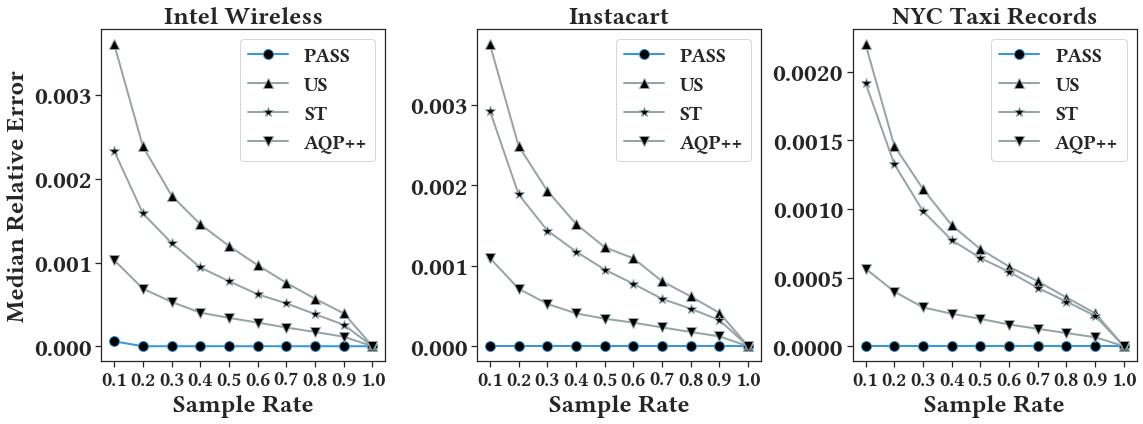

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


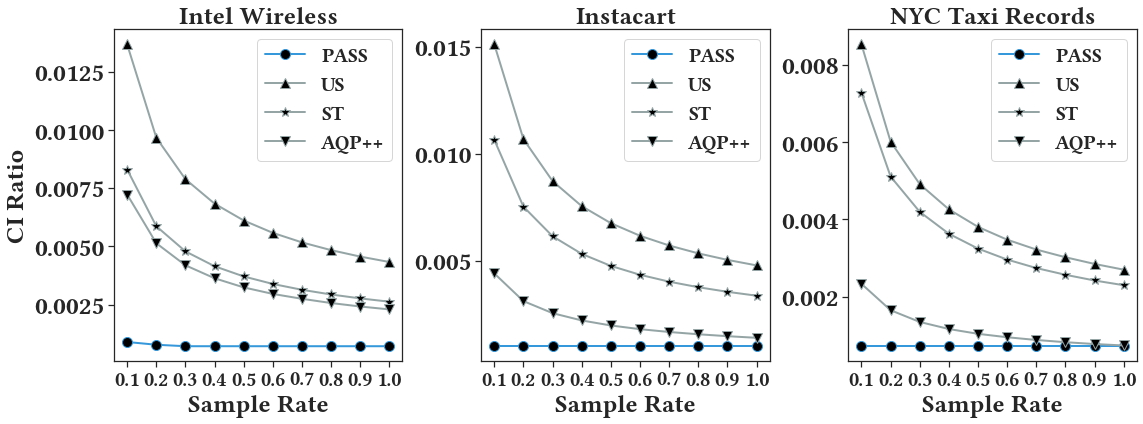

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [11]:

plot_percentile_2_columns({
                            'Intel Wireless': intel['by_sr'],
                            'Instacart': insta['by_sr'],
                            'NYC Taxi Records': taxi['by_sr'],
                            }, log_scale=False, 
                          metric_id=0, percentiles=[50], show_avg=False, 
                          xlabels = ['Sample Rate','Sample Rate','Sample Rate'], title = None, show_p = False, y_label = 'Median Relative Error', 
                          fname='macro-RE-sr')



plot_percentile_2_columns({
                            'Intel Wireless': intel['by_sr'],
                            'Instacart': insta['by_sr'],
                            'NYC Taxi Records': taxi['by_sr'],
                            }, log_scale=False, 
                          metric_id=3, percentiles=[50], show_avg=False, 
                          xlabels = ['Sample Rate','Sample Rate','Sample Rate'], title = None, show_p = False, y_label = 'CI Ratio', 
                          fname='macro-OldCIRatio-sr')


dict_keys(['by_sr', 'by_k']) dict_keys(['by_sr', 'by_k']) dict_keys(['by_sr', 'by_k'])


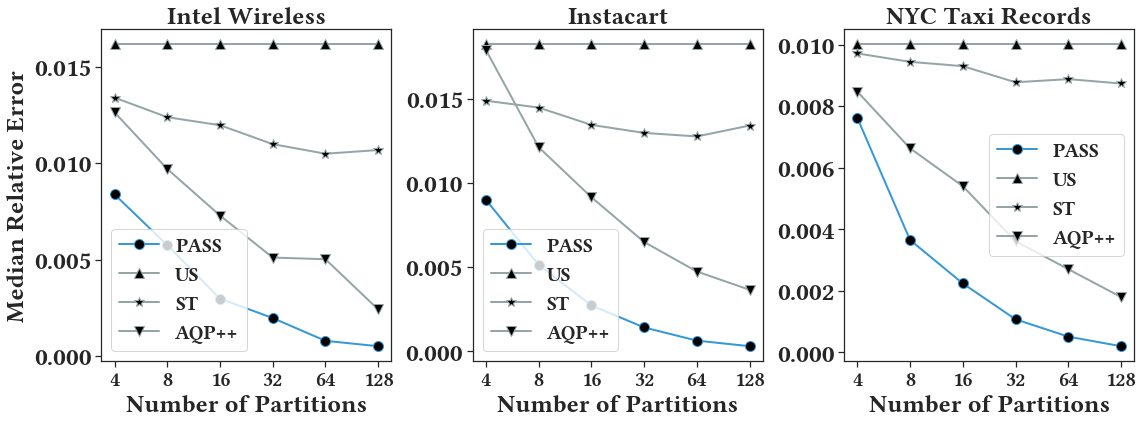

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


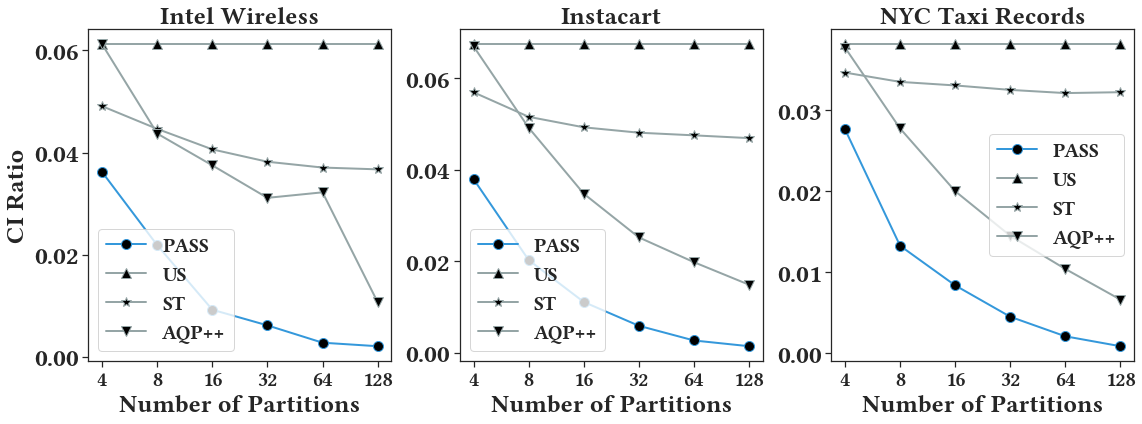

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [12]:
print(intel.keys(), insta.keys(), taxi.keys())
plot_percentile_2_columns({
                            'Intel Wireless': intel['by_k'],
                            'Instacart': insta['by_k'],
                            'NYC Taxi Records': taxi['by_k'],
                            }, log_scale=False, 
                          metric_id=0, percentiles=[50], show_avg=False, 
                          xlabels = ['Number of Partitions','Number of Partitions','Number of Partitions'], title = None, show_p = False, y_label = 'Median Relative Error', 
                          fname='macro-RE-k')
plot_percentile_2_columns({
                            'Intel Wireless': intel['by_k'],
                            'Instacart': insta['by_k'],
                            'NYC Taxi Records': taxi['by_k'],
                            }, log_scale=False, 
                          metric_id=3, percentiles=[50], show_avg=False, 
                          xlabels = ['Number of Partitions','Number of Partitions','Number of Partitions'], title = None, show_p = False, y_label = 'CI Ratio', 
                          fname='macro-OldCIRatio-k')
